In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)

    n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    pitch = 1.
    t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
    t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
    t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

    n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
    t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
    extra   = np.ones((1,N_angle*N_offset,1))
    origin  = (0., 0.)
    pitch   = (1.,1.)

    t_spec  = cp.array(t_spec)
    n_spec  = cp.array(n_spec)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2

def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/xdesign/phantom/phantom.py:375: RuntimeWarning: Reached termination criteria of 500 attempts before adding all of the circles.
  warnings.warn((


(3000, 3000)


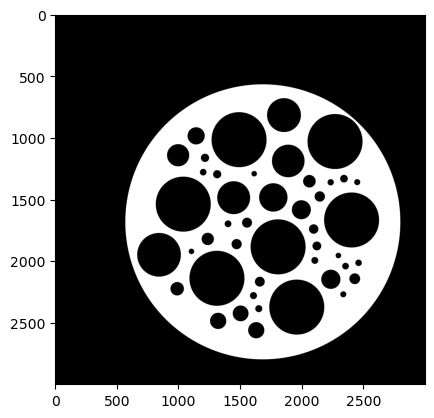

In [15]:
#interactive matplotlib backend

N_side = 3000 #5000

phantom = create_phantom(N_side, "sharp")

# load phantom
#phantom = cp.array(np.load('phantom.npy'))

arg_shape = phantom.shape
print(arg_shape)
plt.figure()
plt.imshow(phantom.get(), cmap='gray')
plt.show()


/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_9gwf2btx:[2025-02-17 21:36:34.972225] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_9gwf2btx:[2025-02-17 21:36:35.201930] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_9gwf2btx:[2025-02-17 21:36:35.213164] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_9gwf2btx:[2025-02-17 21:36:35.224082] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_9gwf2btx:[2025

sample normal
norm diff splines :  3705.261044202138
norm diff pixels  :  3657.4631803564157


Oversampled
norm diff splines :  82256.84243785201
norm diff pixels  :  115499.3468078316
14269.93898327139
14207.537253722221


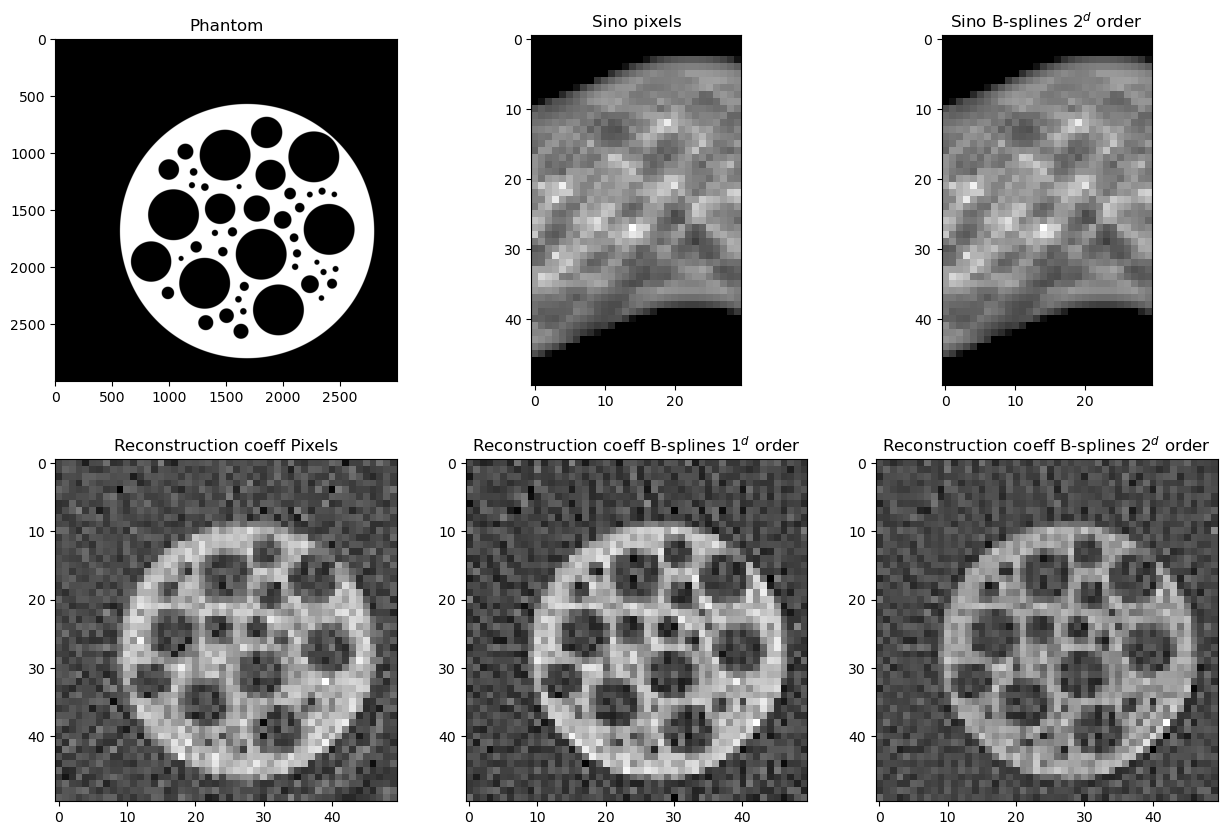

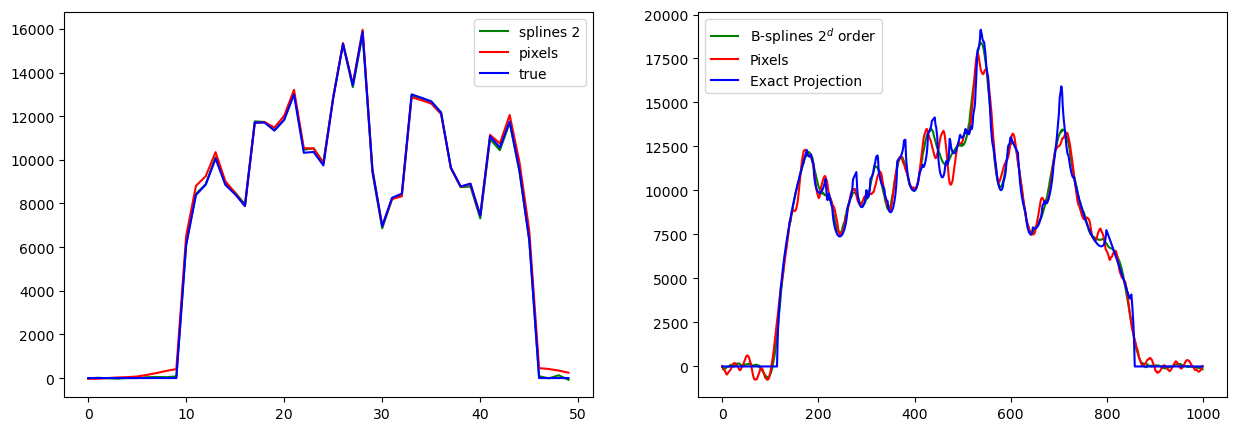

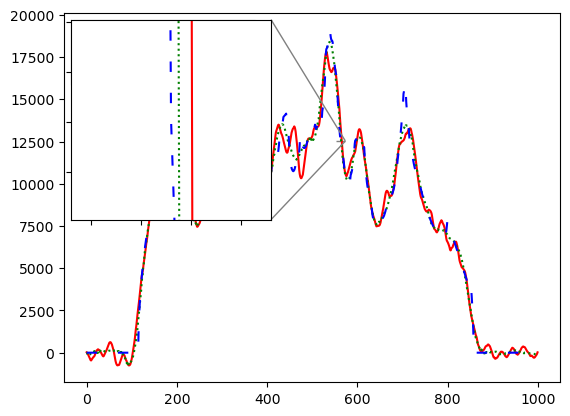

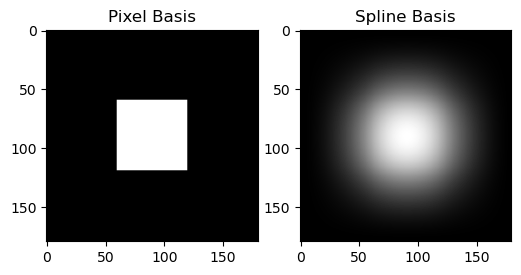

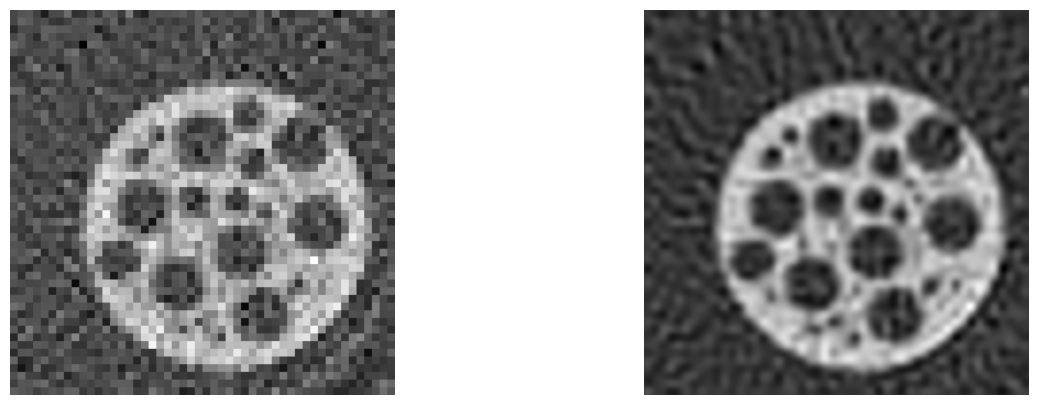

In [4]:

pitch_op = (1.,1.) 
N_angle  = 30
N_offset = 50
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

N_offset_true = 1000
op_true, _, _ = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() 
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get()
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() 
sinogram_astra = fwd_pixels

stop_crit = pxst.MaxIter(30)

oversampling = 50
pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
arg_shape = (oversampling, oversampling)
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_pixels.T, cmap='gray')
axes[0, 1].set_title('Sino pixels')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()

N_offset = 1000
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

NN = phantom.shape[0]//oversampling
mini_im = np.zeros((3*NN, 3*NN))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[NN:2*NN, NN:2*NN] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')
mini_im_spline = spconv(mini_im_spline, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')

ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(full_im_pix[NN:-NN, NN:-NN], cmap='gray')
ax[1].imshow(full_im_spline[NN:-NN, NN:-NN], cmap='gray')
for a in ax:
    a.axis('off')
plt.savefig('upsampled.eps', format='eps')

print(np.linalg.norm(full_im_pix[NN:-NN, NN:-NN]/np.max(full_im_pix[NN:-NN, NN:-NN]) - phantom.get()))
print(np.linalg.norm(full_im_spline[NN:-NN, NN:-NN]/np.max(full_im_spline[NN:-NN, NN:-NN]) - phantom.get()))

plt.show()

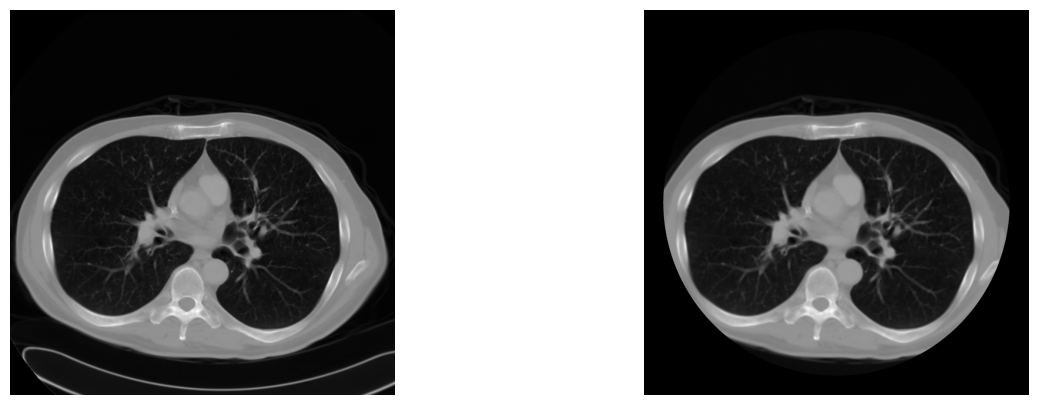

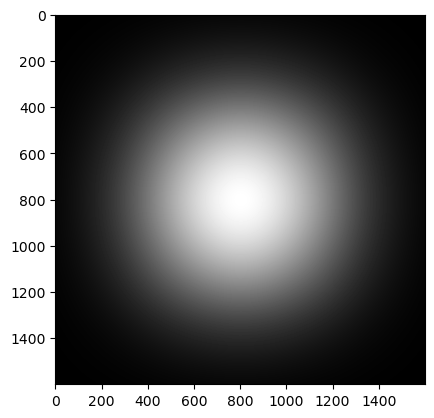

In [40]:
import astra 

N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[:500, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 0.9
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    angles = np.linspace(0, np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = N_side/N_offset
    proj_geom = astra.create_proj_geom('parallel', det_spacing, N_offset, angles)
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    sinogram_id, y_data = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)
    
    stop_crit = pxst.MaxIter(20)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling
    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]


    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    
    plt.show()

    return loss1, loss2, loss3


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.563486] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.583943] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.594682] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.605087] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.615416] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.625814] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.636239] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.646595] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48

Oversampling :  20


INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.667552] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.677796] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.688044] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.698471] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.708690] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.718885] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.729189] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.739445] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.749697] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.759869] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_rrgf3_4b:[2025-02-17 22:23:48.770090]

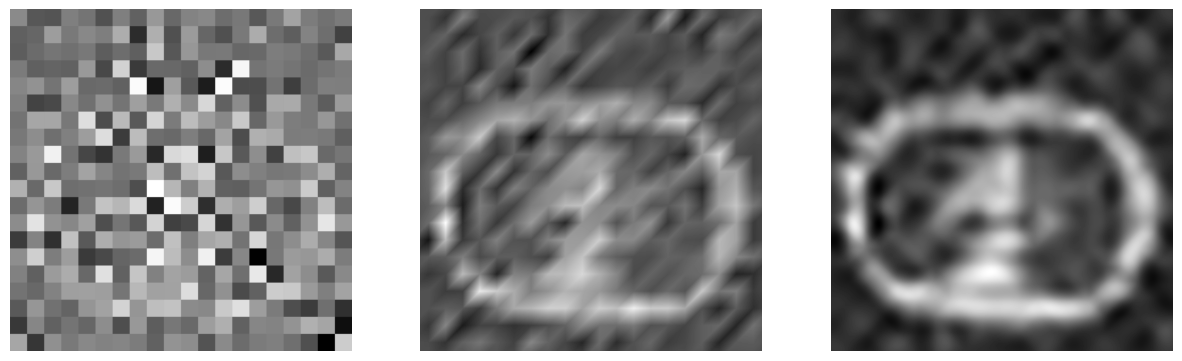

INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.292639] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.310444] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.321643] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.332716] Iteration 3
	iteration: 3
	N_iter: 4.0


Losses :  9.343118892793624 16.25366175399564 16.13469964416229
Oversampling :  40


INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.344744] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.355814] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.366914] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.377995] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.388990] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.400021] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.411003] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.421948] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.432912] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.443896] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_r5vg14va:[2025-02-17 22:24:01.455167] Iteration 14
	

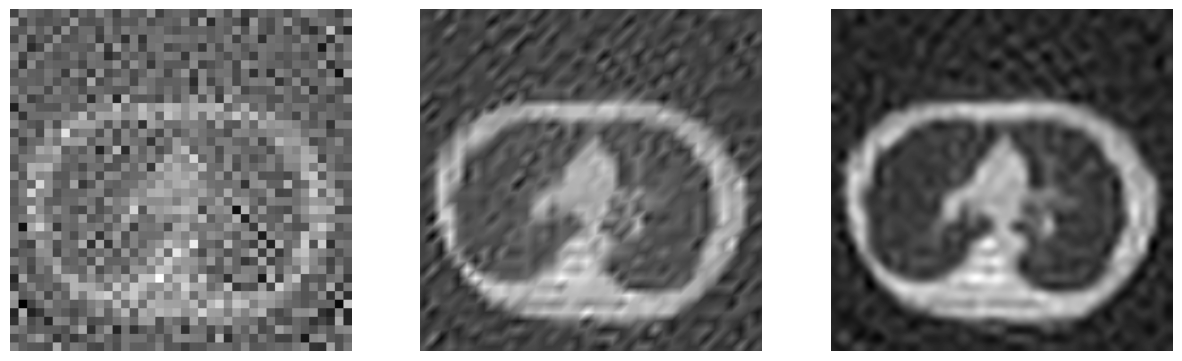

INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.032272] Iteration 0
	iteration: 0
	N_iter: 1.0


Losses :  13.251650188449027 19.51953756469433 19.930563821778488
Oversampling :  50


INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.052873] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.064250] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.075362] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.086560] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.097820] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.109061] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.120291] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.131508] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.142793] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.153846] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_ie9b0xo5:[2025-02-17 22:24:14.164899] Iteration 11
	iteration

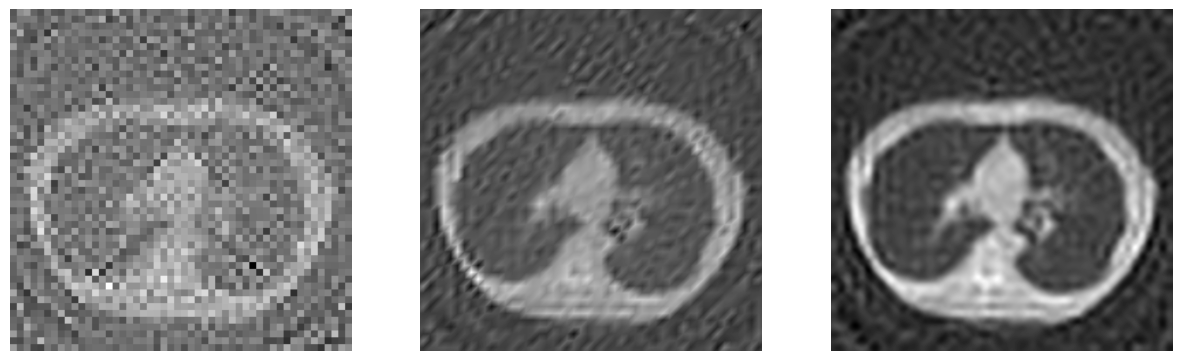

Losses :  14.127501131043825 19.915261021735308 20.983803609907493
Oversampling :  75


INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.905298] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.924807] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.936014] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.947679] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.958830] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.969917] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.981004] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:26.992089] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:27.003187] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:27.014311] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_2t6yfq48:[2025-02-17 22:24:27.025394] Iteration 10
	iteration: 1

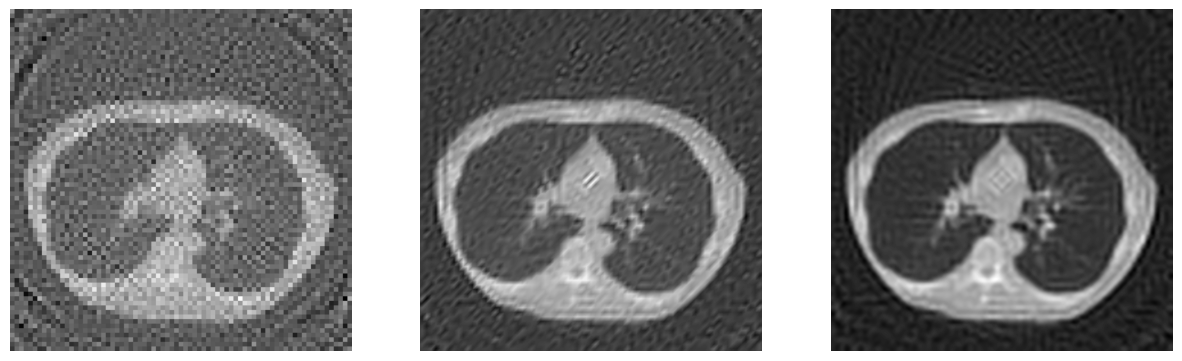

Losses :  16.757658153512804 22.71104611011711 23.697339473111455
Oversampling :  100


INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.163806] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.184275] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.195746] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.206975] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.217999] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.229040] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.240208] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.251350] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.262360] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.273397] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_7x51487b:[2025-02-17 22:24:40.284402] Iteration 10
	iteration: 1

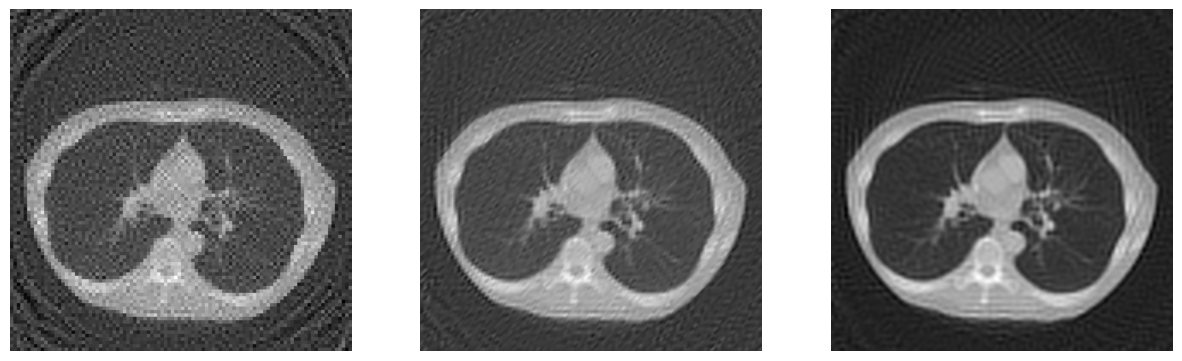

Losses :  19.91070037931986 24.57179326140499 25.168585760770426
Oversampling :  120


INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.701522] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.720697] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.732020] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.743260] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.754550] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.765772] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.776946] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.788228] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.799490] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.810549] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_1qttjh_d:[2025-02-17 22:24:53.821659] Iteration 10
	iteration: 1

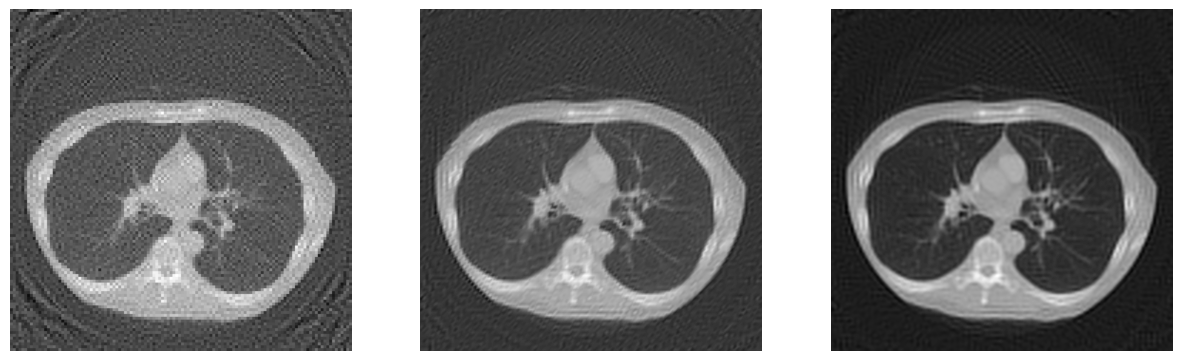

Losses :  20.828031084485318 25.905614637448494 26.72662817163062
Oversampling :  150


INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.801662] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.823293] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.834667] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.845807] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.856854] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.867898] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.879090] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.890174] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.901219] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.912361] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_6kloqvse:[2025-02-17 22:25:07.923541] Iteration 10
	iteration: 1

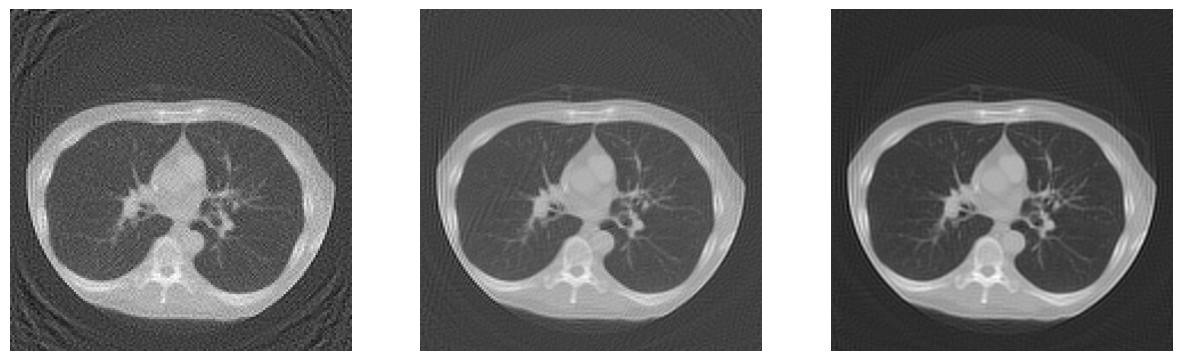

Losses :  22.539621905410584 27.843868397704746 28.855825659607596
Oversampling :  200


INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.682902] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.701296] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.712778] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.724037] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.735385] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.746603] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.757711] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.768834] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.780014] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.791086] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_es2dydwk:[2025-02-17 22:25:22.802078] Iteration 10
	iteration: 1

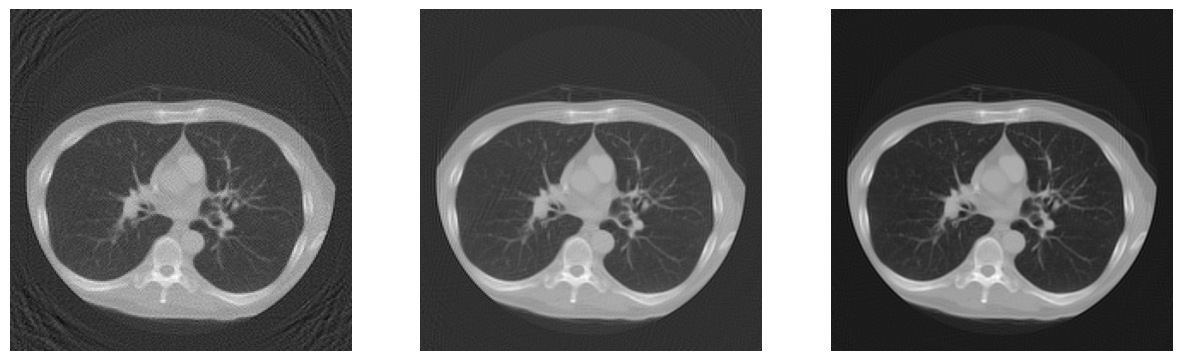

Losses :  25.7721477136454 29.642986244234656 30.238407174425568
Oversampling :  250


INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.777400] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.796645] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.807906] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.819063] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.830127] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.841251] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.852492] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.863629] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.874658] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.885964] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_00b5yny6:[2025-02-17 22:25:38.897082] Iteration 10
	iteration: 1

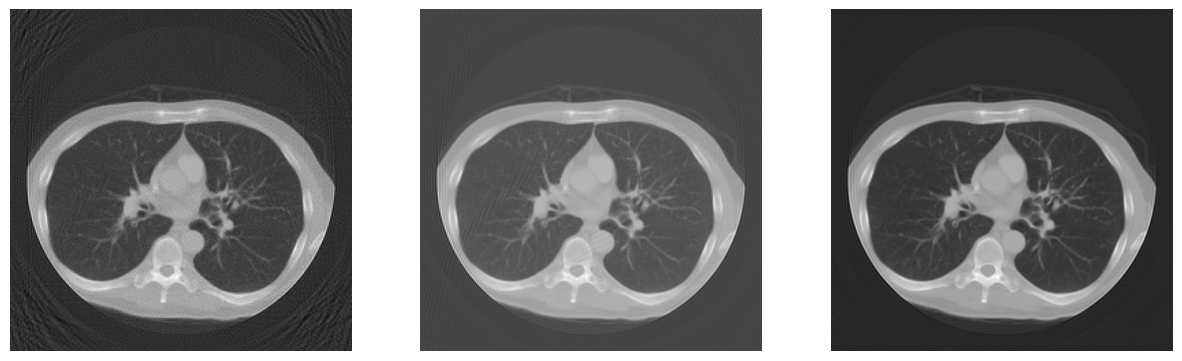

Losses :  27.447507994282745 31.690412079532358 32.88626873997564
Oversampling :  300


INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.177939] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.198342] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.209967] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.221417] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.232788] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.244160] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.255590] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.267034] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.278384] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.289764] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_k0rvmv2k:[2025-02-17 22:25:56.301221] Iteration 10
	iteration: 1

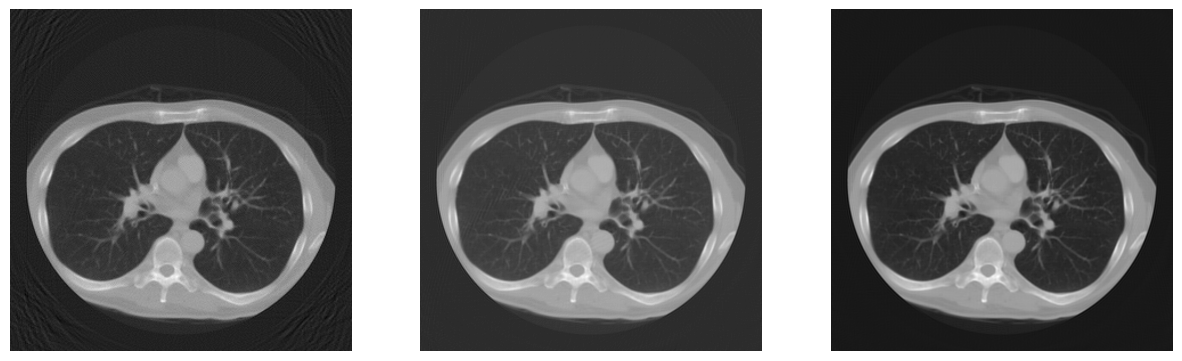

Losses :  29.327256194050747 32.64146594258554 33.18024514481486
Oversampling :  375


INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.447573] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.468974] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.481232] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.493508] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.505693] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.517807] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.530030] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.542122] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.554192] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.566273] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_hzfx6nuu:[2025-02-17 22:26:16.578409] Iteration 10
	iteration: 1

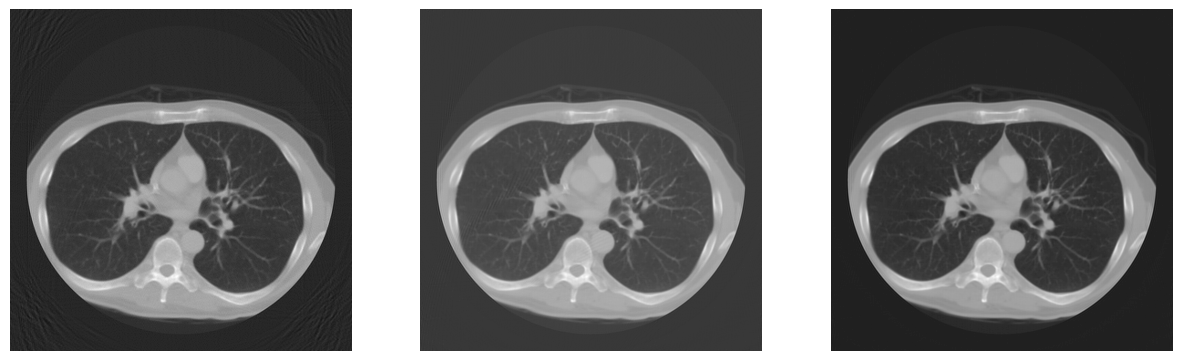

Losses :  31.044377315585464 34.28596783483102 34.95336270368703
Oversampling :  500


INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.452884] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.474194] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.488312] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.502425] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.516538] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.530516] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.544666] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.558643] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.572680] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.586690] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_9iz9zfiz:[2025-02-17 22:26:41.600773] Iteration 10
	iteration: 1

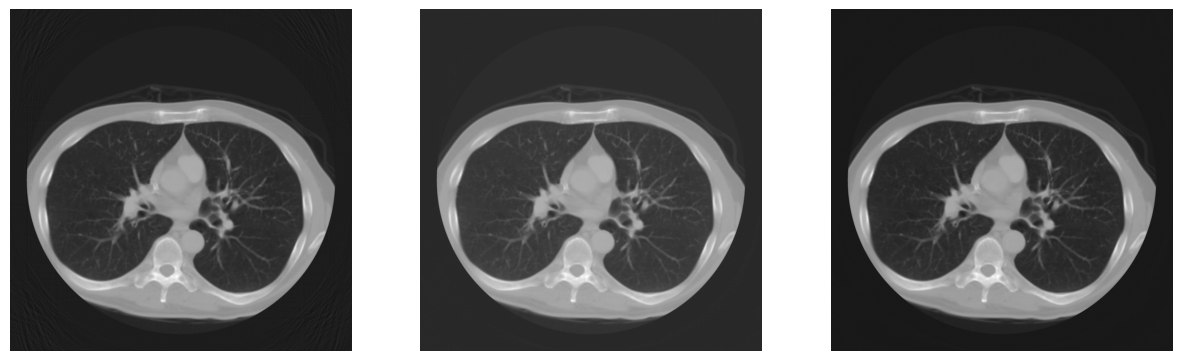

Losses :  33.699663007724745 36.00002350243726 36.40572180204651


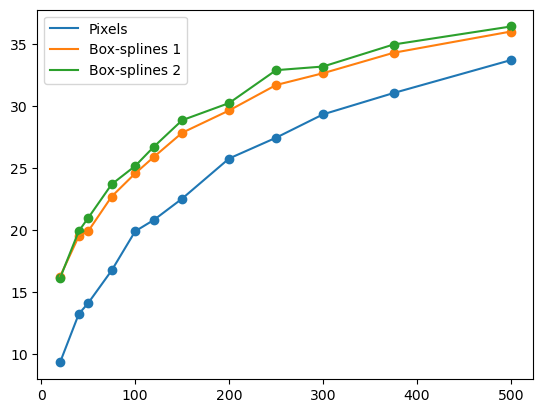

In [41]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500]#, 1000, 1250, 2500, 5000]

losses1 = []
losses2 = []
losses3 = []
for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3 = run_xp(oversampling, oversampling, oversampling, phantom)
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    print('Losses : ', loss1, loss2, loss3)

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels')
plt.plot(oversamplings, losses2, label='Box-splines 1')
plt.plot(oversamplings, losses3, label='Box-splines 2')
plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.legend()
plt.show()